# Notebook overview

### Section A: Loading data 
- Load data that was processed in the previous notebook (NB_01_dataProc.ipynb)

### Section B: cross-validation using SVM-RBF
- Train SVM-RBF (support vector machine with radial basis function) one two feature sets
- Feature set 1 = "Av_all" - where the all spatial information is removed by averaging the voxels for each patient 
- Feature set 2 = "Av_ROI" - where the voxel information is averaged into anatomical regions of interest (i.e. Frontal, central, parietal). This feature set was made to see if that simply averaging all anatomical information as in Av_all lost useful information
- models are trained using a nested leave-one-out cross validation scheme to give an accurate representation on how the models might perform on unseen data
- Here cross-validation central to the assessment of model performance

### Section C: Bayesian treatment of confusion matrix
- Using a Bayesian framework treat the results for the confusion matrix as a probability distribution

# Import libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import arviz as az

# Import my custom functions  

In [2]:
import os
import sys
scr_dir = os.path.join(os.getcwd(),'..', 'scr')
sys.path.append(scr_dir)

# import custom functions
from d03_modeling.NestedL00CV import f_NestedL00CV
from d02_ploting.plotCM import plotCM
from d04_metrics.PostiriorBalACC import f_betaAvPDF, f_plot_post, calcBetaParams
from d04_metrics.splineConv import splineConv 
from d04_metrics.Metropolis_Hastings import Metropolis_Hastings



## Section A: Load data

In [3]:
data = {'avAll': np.nan, 'avROI': np.nan}

data['avAll'] = pd.read_csv('../data/d02_intermediate/AllVox_av/AllVox_av.csv')
data['avAll'].head()

Code  sPCr_sATPg  sPCr_All.1  sATPg_All.1   spH  Outcome_B
0  P01        1.06        0.47         0.45  7.03          0
1  P02        1.10        0.48         0.44  7.02          1
2  P03        1.41        0.52         0.37  7.29          0
3  P04        1.00        0.42         0.42  7.15          0
4  P05        1.09        0.46         0.42  7.10          0

In [4]:
data['avROI'] = pd.read_csv('../data/d02_intermediate/ROI_data_prep/ROI_data_prep.csv',header=[0,1])
data['avROI'].head()

Code          Outcome_B sPCr_sATPg                      \
  Unnamed: 0_level_1 Unnamed: 1_level_1    Central   Frontal Pariental   
0                P01                  0   1.083125  0.968460  1.169807   
1                P02                  1   0.955384  1.249298  1.029488   
2                P03                  0   1.390949  1.364203  1.514456   
3                P04                  0   1.081194  0.974503  0.945363   
4                P05                  0   1.279272  0.892715  1.085993   

  sPCr_All.1                     sATPg_All.1                           spH  \
     Central   Frontal Pariental     Central   Frontal Pariental   Central   
0   0.468559  0.453514  0.504080    0.433086  0.469021  0.431136  7.036401   
1   0.446524  0.505318  0.464997    0.467868  0.405806  0.451681  7.044047   
2   0.548730  0.489711  0.529131    0.394153  0.359493  0.352556  7.300956   
3   0.478568  0.374534  0.436783    0.444864  0.384044  0.462443  7.102437   
4   0.506067  0.404869  0.455468    0.396776  0.453063  0.424919  7.061053   

                       
    Frontal Pariental  
0  7.072348  6.977375  
1  7.004815  7.032077  
2  7.226630  7.358896  
3  7.125732  7.250218  
4  7.131756  7.096405

## Section B: Nested leave-one-out cross-validation
In machine learning analysis the whole data set is commonly split into a testing and training set, a process called the test/train split. Cross-validation is then performed on the training set to gauge how generalisable the models predictive power is to unseen data and how stable the model is when training on different subsets of the data. The most suitable model is then used to predict the unseen test data set. However, since our data set is small (n=23) and multiclass, a 26%/74% test/train split would result in a testing set with 6 subjects. The performance metrics calculated for each class would be very sensitive to noise, how you divide the data set and have very large intrinsic confidence intervals. It was therefore decided to perform nested leave-one-out cross-validation (nLOOCV) on the entire data set, as done previously in \citep{Vabalasid2019MachineSize, Vergara2017, Ambroise2002}. The nested leave-one-out framework built here allows for generalisability of the classifiers predictions and stability to be evaluated. 

Vermon et al (2006) \citep{Varma2006BiasSelection} noted that this nested procedure can produce almost unbiased approximation of the true model accuracy. In essence this two layered nested approach allows for the processes of model tuning and testing to be decoupled, tackling the common issues of over-optimistic assessment of a model's predictive performance (i.e. overfitting). 

The figure below Figure describes the cross-validation framework implemented in here. The subjects in the data set are divided into n folds - since a leave-one-out procedure is used, each of these folds corresponds to a single subject. In the first iteration of the outer loop one of the folds is labelled the 'outer-test-set' and the remaining n-1 folds are grouped into an 'outer-train-set'. This outer-train-set is passed to the inner loop where 'feature scaling', 'feature selection' and 'hyperparameter tuning' are performed. The hyperparameter tuning gird search finds the set of hyperparameters that maximise model performance (i.e. prediction accuracy of subject status) across all the 'inner-test-set' results. These hyperparameter settings are used to train a model on the 'outer-train-set' ready for predicting the 'outer-test-set'. Since this outer-test-set is left out at the beginning of the model development process the model is completely uninformed by that instance (i.e. subject), mitigating data leakage. This process is repeated n times until all instances of the data have been left out in the outer loop and their class label predicted (i.e healthy control, TBI-favourable outcome and TBI-unfavourable outcome). The key point here is that a model is tested on instances independent of the data used to fit the model, avoiding the need to make any assumptions on the data being tested, for example how the data is distributed. With regard to the small size of this data set (n=23) an additional advantage of the leave-one-out cross-validation approach is that it allows re-use of data for the training.


(-0.5, 1317.5, 721.5, -0.5)

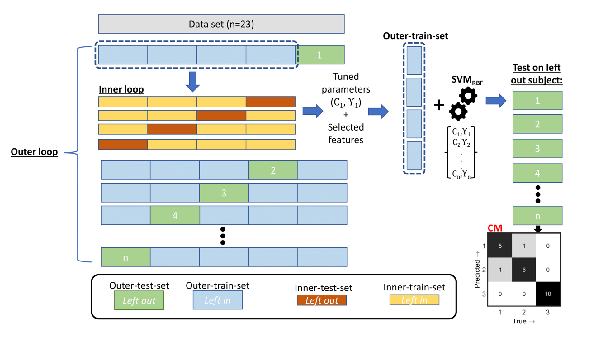

In [5]:
import imageio as iio
img = iio.imread('../references/LOOC_CVScheme_new3_new.png')
plt.figure(figsize = (50,6))
plt.imshow(img)
plt.axis('off')
plt.title('Nested leave-one-out cross validation scheme.')


In [6]:
# create dicts to store the x and y elements of all data sets
X_data = {'avAll': np.nan, 'avROI': np.nan}
y_data = {'avAll': np.nan, 'avROI': np.nan}


# hyper parameter values to be used
par_grid_SVM={'C':[0.05,0.1,0.5,1,5,10],'gamma':[2.0,1.0,0.5,0.25,0.125,0.0625,0.03125,0.015625]} # difine grid of SVM-RBF hyper parameters

# prep data for leave one out cross validation
X_data['avAll'] = data['avAll'].iloc[:, 1:5]
y_data['avAll'] = data['avAll'].iloc[:,5] 


In [7]:
SVM_hypers_df = pd.DataFrame(index=np.arange(1,24),    # was 18
                             columns=['AV_SVM-RFE:C', 'AV_SVM-RFE:gamma', 
                                      'ROI_SVM-RFE:C', 'ROI_SVM-RFE:gamma'])

# Define data frame where I want to store the LOOCV accuracies
SVM_LOOCV_acc_df = pd.DataFrame(index=np.arange(1), columns=['AV_SVM-RFE','ROI_SVM-RFE'])

In [8]:
# create a dictionary for y predictions
y_pred = {'avAll': np.nan, 'avROI': np.nan}

# Av_All data set
# run leave one out crossvalidation and store results
SVM_LOOCV_acc_df['AV_SVM-RFE'], SVM_hypers_df['AV_SVM-RFE:C'], SVM_hypers_df['AV_SVM-RFE:gamma'], inner_loop_acc_clf_fS, y_pred['avAll'] = f_NestedL00CV(X_data['avAll'], y_data['avAll'], 1, 1, par_grid_SVM)

In [9]:
# Av ROI data set
X_data['avROI'] = data['avROI'].drop(columns={'Code', 'Outcome_B'})
y_data['avROI'] = data['avROI'].Outcome_B
# run leave one out crossvalidation and store results
SVM_LOOCV_acc_df['ROI_SVM-RFE'], SVM_hypers_df['ROI_SVM-RFE:C'], SVM_hypers_df['ROI_SVM-RFE:gamma'], inner_loop_acc_clf_FS, y_pred['avROI'] = f_NestedL00CV(X_data['avROI'], y_data['avROI'], 1, 1, par_grid_SVM) # Feature selection on


C:\Users\My PC\Anaconda3\envs\TBI_PatientOutcomePred_Venv\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


(<Figure size 432x288 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026E4658AA48>,
       dtype=object))

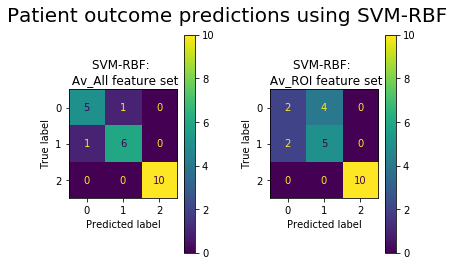

In [10]:
CM = {'avAll':np.nan, 'avROI': np.nan}

# based on the predictions make make the confusion matricies
CM['avAll'] = ConfusionMatrixDisplay(confusion_matrix(y_data['avAll'], 
                                        y_pred['avAll']), display_labels=['0','1','2'])

CM['avROI']= ConfusionMatrixDisplay(confusion_matrix(y_data['avROI'], y_pred['avROI']), 
                                        display_labels=['0','1','2'])

CM_title = ['Patient outcome predictions using SVM-RBF']
CM_subtitles = ['SVM-RBF: \n Av_All feature set', 'SVM-RBF: \n Av_ROI feature set']

# plot confusion matrices
plotCM(CM, CM_title, CM_subtitles)


## Section C: Bayesian treatment of the confusion matrix

Point estimates derived from confusion matrices are predominantly used in the clinical literature, where sample size is nearly always small. As already alluded to, errors reported for these point estimates often do not reflect the errors intrinsic to small sample size as they are based on inappropriate distributional assumptions. A common way of estimating confidence intervals of the prediction accuracy is to compute the standard error of the mean: 

\begin{equation}
\frac{\sigma}{\sqrt{n}}
\end{equation}

where $\sigma$ is the standard deviation of your array of binary predictions and $n$ is the total number of predictions. This is predicated on the specific application of the central limit theorem in a binomial context, from which it follows that for $n\ge$30 a binomial distribution is to a good approximation normal. However, at small $ n$ - as is the case in the current chapter - this assumption breaks down calling into question the validity of the confidence interval \citep{Mowla2020AffectiveMetric}. Also, the standard error of the mean is dependent on design choices that should not affect error estimation, like the number of  test instances in each cross-validation fold. Interestingly, estimation of the standard error of the mean across cross-validation folds has empirically been shown to strongly underestimates errors \citep{Varoquaux2018Cross-validationBars} and can also result in dubious error bars that exceed 100 \% \citep{Brodersen2010TheDistribution}. 

Instead of averaging outcomes from different cross-validation folds one can adopt a probabilistic view point of the cross-validation results. Brodersen et al. (2010) \citep{Brodersen2010TheDistribution} suggested taking a Bayesian approach to measure the uncertainty associated with performance metrics, specifically the \emph{balanced accuracy} ($\lambda$). Balanced accuracy describes the arithmetic mean of class specific accuracies and is preferable to simple accuracy since it accounts for class imbalances. Carrillo et al. (2014) \citep{Carrillo2014ProbabilisticAccuracy} defines balanced accuracy ($\lambda$) as

 \begin{equation}
 \lambda = \frac{1}{l} \sum_{i=1}^{l} \theta_i
 \end{equation}
 
where $l$ is the number of classes and $\theta_i$ is the class specific accuracy of class $i$. Chance performance is therefore always $1/l$, even when class populations are imbalanced. When calculating a point estimate the variable $\theta_i$ is exchanged for $\frac{k_i}{n_i}$, where $k_i$ is the number of "True" instances of class $i$. 

Under the Bayesian framework we consider our balanced accuracy to be a metric represented by an uncertainty distribution. Here we can express the balanced accuracy across all classes in terms of a posterior distribution given the observed data,  $P(\lambda | \mathcal{D})$, where $\mathcal{D}$ is the observed data. The posterior distribution reflects all the possible values of $\lambda$ given the available data.     

For a multiclass problem, as is the case in this chapter, you must consider the class specific accuracies. The outcome of each class specific prediction can be expressed as the outcome of a Bernoulli trial such that

\begin{equation}
p(y_{j}|\theta_i) = Bern(y_{j}|\theta_i) = \theta^{y_{j}}_i(1-\theta_i)^{1-y_{j}}
\end{equation}

where $\theta_i$ is the class specific accuracy of class $i$ and $y_j$ is the outcome of a single Bernoulli experiment. It directly follows that the number of correct predictions $k$ in a sequence of n Bernoulli trials follows a binomial distribution

\begin{equation}
p(k_i|\theta_i,n_i) = Bin(k_i|\theta_i,n_i)= \binom{n_i}{k_i} \theta^{k_i}_i(1-\theta_i)^{n_i-k_i}
\end{equation}

where $k_i$ and $n_i$ are the number of correct predictions and total instances of class $i$, respectively. In a Bayesian context this becomes our "likelihood" distribution. Any available prior knowledge about classification can be injected by placing a prior on $\theta_i$ using the conjugate prior of the binomial distribution, the beta distribution. Here the maximal prior uncertainty (i.e. the flat prior) was chosen to not unintentionally introduce bias into error estimations. Given the observed variable $k_i$ and $n_i$ for each class $i$, posterior distributions of class specific accuracies ($\theta_i$) can be computed

\begin{equation}
p(\theta_i | k_i, n_i) = \frac{Bin(k_i|\theta_i,n) \times Beta(\theta_i|1,1)}{p(k_i)} \\ = Beta(\theta_i|k_i+1,n_i-k_i+1)\label{eq:postDis}
\end{equation}

where $Beta(\theta_i|1,1)$ acts as the flat prior or Laplace prior and $k_i$, $n_i$ are viewed as fixed variables at the observed values while $\theta_i$ ranges from 0 to 1. The class-specific posterior distribution accuracies $P(\theta_i |k_i,n_i)$ are more generally defined as

\begin{equation}
p(\theta_i|k_i,n_i,a,b)=Beta(\theta_i |a+k_i,n_i-k_i+b)\label{eq:classPostACC}
\end{equation}

where a and b define the initial prior knowledge of classification. The confusion Matrices above shows the multiclass confusion matrix results of the SVM$_{RBF}$ algorithm training on the Av\_All feature set (left) and Av_ROI feature set (right). From this the class specific Beta distribution accuracies are computed using Equation \ref{eq:postDis} for each of the three subject groups; unfavourable outcomes, favourable outcomes and healthy controls. 

To compute the posterior balanced accuracy across all classes we convolve the class specific probability densities functions (PDFs) obtained in Equation \ref{eq:classPostACC} (shown in Figure below), generating the conditional distribution over the balanced accuracy, $\lambda$. Since the convolution of two functions of random independent variables is equivalent to the product of the functions' Fourier transforms \citep{Carrillo2014ProbabilisticAccuracy} the posterior distribution of the balanced accuracy is given by 

\begin{equation}
p(\lambda | \mathcal{D}) = \mathcal{F}^{-1}\{\frac{1}{3} \times \mathcal{F} \{\theta_1\} \times \mathcal{F} \{\theta_2\} \times \mathcal{F} \{\theta_3\} \} \label{eq:convol}
\end{equation}

where $\mathcal{F}\{ .\}$ and $\mathcal{F}^{-1}\{ .\}$ are the Fourier transform and inverse Fourier transform, respectively \citep[p. 272]{Leon-Garcia1994ProbabilityAddison-Wesley}, $P(\lambda | \mathcal{D})$ is the posterior distribution of the balanced accuracy across all classes and $\mathcal{D}  =\{(k_1,n_1), ..., (k_l,n_l)\}$ are the results from the confusion matrix. 

### Posterior distribution of the balanced accuracy -- Results 
The figure below shows the posterior distribution of the balanced accuracy of the cross-validation results when the SVM-RBF algorithm is trained on the Av_all feature set and Av_ROI feature set. The shaded blue regions show the 95 % HDI (Highest Density Interval). The cross-validation results are above the 33 % chance level (black dashed line) for both feature sets. To understand if these cross validation results are significantly different we must sample from the two distributions. See below.


In [11]:
# Make a dic to store the parameters for the class specific beta disributions 
betaParams = test = {'avAll':np.nan , 'avROI': np.nan}

# define flat beta prior
Betaprior = {'a': 1, 'b': 1}

# calc beta ditribution parameters for class specifica accuracies 
# of avAll and avROI results
betaParams['avAll'] = calcBetaParams(CM['avAll'], Betaprior)
betaParams['avROI'] = calcBetaParams(CM['avROI'], Betaprior)


(1000,)
(1000,)


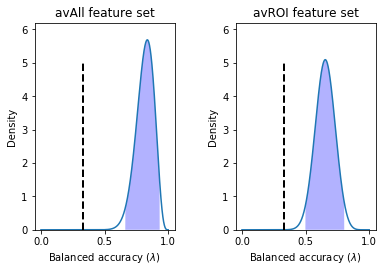

In [12]:
# Create a dict to store convolved PDFs 
convPDF = {'avAll':np.nan , 'avROI': np.nan}

res = 0.001
x = np.arange(0,1, res)

# convalte the class specific beta distributinos together for the results from both feature sets
convPDF['avAll'] = np.real( f_betaAvPDF(x, betaParams['avAll']) )
convPDF['avROI'] = np.real( f_betaAvPDF(x, betaParams['avROI']) )

# '95% HDI of postieror distribution'
alpha = 0.05  # significance level
chance = 1/np.shape(betaParams['avAll'])[0] # chance level
title = ['1', '2']
ax = f_plot_post(x, convPDF, alpha, 'blue', chance, title)



### Comparing classifiers
The question of whether one classifier outperforms another can be deduced by considering the difference in respective posterior distributions, i.e. $P(\lambda_1|\mathcal{D})$ and $P(\lambda_2|\mathcal{D})$, given by

\begin{equation}
P(\delta | \mathcal{D})
\end{equation}

where $\delta$ = $\lambda_1$ - $\lambda_2$ indicates the difference in posterior distribution of the balanced accuracy. This posterior distribution is calculated numerically using the metropolis hasting algorithm \citep{Carrillo2014ProbabilisticAccuracy}. Samples of $P(\lambda_1|\mathcal{D})$ and $P(\lambda_2|\mathcal{D})$ are stochastically taken and the difference in balanced accuracy between each pairwise sample is recorded to build up a $P(\delta | \mathcal{D}) $ distribution of 50,000 points. The figure below shows a comparison of the cross validation results between the two feature sets (See anatomical image in the previous notebook NB_01_dataProc.ipynb). 

The Black horizontal line shows the 95% HDI of the difference of the two cross validation results. Since this contains the zero $\delta$ point it means that the cross-validation results between the two feature sets are not significant at the 95% level. The Av_ROI feature set almost produced significantly better predictions. 

In [13]:
# make to dic to store postiror PDF's and one to store my sampling from the metropalis hasting algorithm
SampPDF = {'avAll':np.nan , 'avROI': np.nan}
samples = {'avAll':np.nan , 'avROI': np.nan}


#SampPDF = [ splineConv(betaParams[key], res) for key in SampPDF.keys()]
#[ {key: splineConv(betaParams[key], res)} for key in SampPDF.keys()]

# sample from both postiroior distributionss
for key in SampPDF:
    SampPDF[key] = splineConv(betaParams[key], res)
    samples[key] = Metropolis_Hastings(SampPDF[key], iter=1000000)

del key






(1000,)


g:\My Drive\DataSciProjs\PhD_proj\TBI_PatientOutcomePrediction\TBI_Patient_outcome_pred\notebooks\..\scr\d04_metrics\Metropolis_Hastings.py:14: RuntimeWarning: invalid value encountered in greater
  if np.random.rand() < p(x_star) / p(x):


(1000,)


C:\Users\My PC\Anaconda3\envs\TBI_PatientOutcomePred_Venv\lib\site-packages\arviz\data\base.py:221: UserWarning: More chains (1000000) than draws (1). Passed array should have shape (chains, draws, *shape)
  UserWarning,


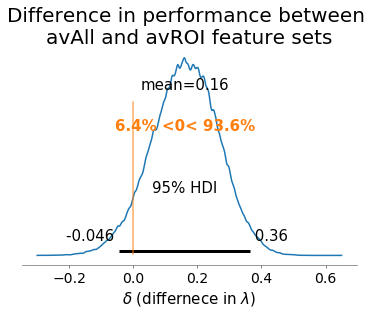

In [14]:
sampDiff = samples['avAll'] - samples['avROI']
ax = az.plot_posterior(sampDiff,hdi_prob=0.95, ref_val=0)

ax.set_title('Difference in performance between \n avAll and avROI feature sets', fontsize=20)
#ax.set_xlabel('BalAcc(avAll) - BalAcc(avROI)', fontsize=15)
ax.set_xlabel('$\delta$ (differnece in $\lambda$)', fontsize=15);



## Conclusions
- The SVM-RBF gave cross-validation predictions of patient outcome significantly above chance level when training on the low dimensionality Av_all (Balanced accuracy = 81 %) and higher dimensionality Av_ROI (Balanced accuracy = 65.3 %) data set 
- Large error intervals were managed by considering the posterior distribution of the balanced accuracy
- When training on the av_All feature set the results were almost more significantly better than when training on the Av_ROI feature set 
- The poorer performance when using the Av_ROI features set is likely because the ration between the number of features and the number of subjects is high -- likely leading to overfitting problem 